In [2]:
import pickle 

import matplotlib.pyplot as plt
import seaborn as sns 
import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression

from sklearn.preprocessing import StandardScaler

from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import RandomizedSearchCV, train_test_split, KFold 
from sklearn import svm

from sklearn.metrics import roc_curve, classification_report, confusion_matrix, multilabel_confusion_matrix
from sklearn.metrics import precision_score, accuracy_score, recall_score, precision_recall_curve, f1_score, roc_auc_score
%matplotlib inline

from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

from sklearn.utils.class_weight import compute_class_weight

from sklearn.feature_selection import SelectFromModel

In [3]:
with open('df.pickle','rb') as read_file:
    df = pickle.load(read_file)

In [4]:
df

,age,gender,app_day,month,calling_time_hour,waiting_time_minute,financial_aid,hypertension,diabetes,alcoholism,Handicap,sms_received,day_before_app,show_up,total_conditions
0,22,1,3,5,7,19,0,0,0,0,0,1,0,1,0
1,23,1,4,6,13,21,0,0,0,0,0,1,36,1,0
2,28,1,2,5,16,0,0,0,0,0,0,0,0,1,0
3,28,1,3,5,11,27,0,0,0,0,0,0,1,1,0
4,29,1,6,5,7,2,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72602,90,0,4,5,14,9,0,0,0,0,0,1,0,1,0
72603,90,0,3,5,15,0,0,0,0,0,0,0,13,1,0
72604,90,0,3,5,9,1,0,0,0,0,0,0,0,1,0
72605,90,0,4,5,8,0,0,0,0,0,0,0,8,1,0


In [5]:
# 20% of patients don't show up
df.show_up.value_counts(normalize=True)

1    0.79064
0    0.20936
Name: show_up, dtype: float64

In [6]:
df.describe()

,age,gender,app_day,month,calling_time_hour,waiting_time_minute,financial_aid,hypertension,diabetes,alcoholism,Handicap,sms_received,day_before_app,show_up,total_conditions
count,72607.000000,72607.000000,72607.000000,72607.000000,72607.000000,72607.000000,72607.000000,72607.000000,72607.000000,72607.000000,72607.000000,72607.000000,72607.000000,72607.000000,72607.000000
mean,37.247910,0.663366,3.858016,5.207019,10.880907,9.252662,0.104026,0.197281,0.073147,0.034625,0.021816,0.313634,5.620298,0.790640,0.326869
std,22.723062,0.472562,1.373439,0.470888,3.230154,14.017053,0.305296,0.397949,0.260380,0.182829,0.146084,0.463973,8.198358,0.406855,0.632467
min,0.000000,0.000000,2.000000,4.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,18.000000,0.000000,3.000000,5.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,37.000000,1.000000,4.000000,5.000000,10.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
75%,55.000000,1.000000,5.000000,5.000000,14.000000,14.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,8.000000,1.000000,0.000000
max,115.000000,1.000000,7.000000,6.000000,20.000000,179.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,40.000000,1.000000,4.000000


## Feature Selection

In [7]:
df_eda = df.copy()

In [8]:
### Binning categorical data 
df_eda['age_bins'] = pd.qcut(df_eda['age'],10, duplicates='drop')
df_eda['calling_time_hour_bins'] = pd.qcut(df_eda['calling_time_hour'],5, duplicates='drop')
df_eda['waiting_time_minute_bins'] = pd.qcut(df_eda['waiting_time_minute'],10, duplicates='drop')
df_eda['day_before_app_bins'] = pd.qcut(df_eda['day_before_app'],5, duplicates='drop')

In [9]:
# Binning Dataset
df_eda

,age,gender,app_day,month,calling_time_hour,waiting_time_minute,financial_aid,hypertension,diabetes,alcoholism,Handicap,sms_received,day_before_app,show_up,total_conditions,age_bins,calling_time_hour_bins,waiting_time_minute_bins,day_before_app_bins
0,22,1,3,5,7,19,0,0,0,0,0,1,0,1,0,"(15.0, 22.0]","(5.999, 8.0]","(16.0, 28.0]","(-0.001, 4.0]"
1,23,1,4,6,13,21,0,0,0,0,0,1,36,1,0,"(22.0, 30.0]","(11.0, 14.0]","(16.0, 28.0]","(11.0, 40.0]"
2,28,1,2,5,16,0,0,0,0,0,0,0,0,1,0,"(22.0, 30.0]","(14.0, 20.0]","(-0.001, 1.0]","(-0.001, 4.0]"
3,28,1,3,5,11,27,0,0,0,0,0,0,1,1,0,"(22.0, 30.0]","(9.0, 11.0]","(16.0, 28.0]","(-0.001, 4.0]"
4,29,1,6,5,7,2,0,0,0,0,0,0,0,0,0,"(22.0, 30.0]","(5.999, 8.0]","(1.0, 4.0]","(-0.001, 4.0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72602,90,0,4,5,14,9,0,0,0,0,0,1,0,1,0,"(67.0, 115.0]","(11.0, 14.0]","(6.0, 9.0]","(-0.001, 4.0]"
72603,90,0,3,5,15,0,0,0,0,0,0,0,13,1,0,"(67.0, 115.0]","(14.0, 20.0]","(-0.001, 1.0]","(11.0, 40.0]"
72604,90,0,3,5,9,1,0,0,0,0,0,0,0,1,0,"(67.0, 115.0]","(8.0, 9.0]","(-0.001, 1.0]","(-0.001, 4.0]"
72605,90,0,4,5,8,0,0,0,0,0,0,0,8,1,0,"(67.0, 115.0]","(5.999, 8.0]","(-0.001, 1.0]","(4.0, 11.0]"


In [10]:
def calculate_woe_iv(dataset, feature, target):
    lst = []
    for i in range(dataset[feature].nunique()):
        val = list(dataset[feature].unique())[i]
        lst.append({
            'Value': val,
            'All': dataset[dataset[feature] == val].count()[feature],
            'Show': dataset[(dataset[feature] == val) & (dataset[target] == 1)].count()[feature],
            'No_show': dataset[(dataset[feature] == val) & (dataset[target] == 0)].count()[feature]
        })
        
    dset = pd.DataFrame(lst)
    dset['Distr_show'] = dset['Show'] / dset['Show'].sum()
    dset['Distr_no_show'] = dset['No_show'] / dset['No_show'].sum()
    dset['WoE'] = np.log(dset['Distr_show'] / dset['Distr_no_show'])
    dset = dset.replace({'WoE': {np.inf: 0, -np.inf: 0}})
    dset['IV'] = (dset['Distr_show'] - dset['Distr_no_show']) * dset['WoE']
    iv = dset['IV'].sum()
    
    dset = dset.sort_values(by='WoE')
    
    return dset, iv

In [11]:
for col in df_eda.columns:
    if col == 'show_up': continue
    else:
        print('WoE and IV for column: {}'.format(col))
        df_woe_iv, iv = calculate_woe_iv(df_eda, col, 'show_up')
        print(df_woe_iv)
        print('IV score: {:.2f}'.format(iv))
        print('\n')

WoE and IV for column: age
    Value  All  Show  No_show  Distr_show  Distr_no_show       WoE        IV
98    115    4     1        3    0.000017       0.000197 -2.427400  0.000437
99     98    3     2        1    0.000035       0.000066 -0.635640  0.000020
40     14  718   500      218    0.008710       0.014341 -0.498675  0.002808
50     15  792   556      236    0.009685       0.015525 -0.471851  0.002756
90     92   58    41       17    0.000714       0.001118 -0.448429  0.000181
..    ...  ...   ...      ...         ...            ...       ...       ...
45     70  437   374       63    0.006515       0.004144  0.452333  0.001072
74     63  914   783      131    0.013640       0.008618  0.459148  0.002306
86     84  189   167       22    0.002909       0.001447  0.698164  0.001021
93     88   54    48        6    0.000836       0.000395  0.750654  0.000331
95     94   15    14        1    0.000244       0.000066  1.310270  0.000233

[101 rows x 8 columns]
IV score: 0.06


WoE and 

/Applications/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


     Value    All   Show  No_show  Distr_show  Distr_no_show       WoE  \
93     104      4      1        3    0.000017       0.000197 -2.427400   
106    155      7      2        5    0.000035       0.000329 -2.245078   
99     103      3      1        2    0.000017       0.000132 -2.021935   
77      60     36     16       20    0.000279       0.001316 -1.551931   
119    142      2      1        1    0.000017       0.000066 -1.328788   
..     ...    ...    ...      ...         ...            ...       ...   
122    117      1      1        0    0.000017       0.000000  0.000000   
81      85     11      9        2    0.000157       0.000132  0.175290   
47      62    112     93       19    0.001620       0.001250  0.259373   
92      73     18     15        3    0.000261       0.000197  0.280650   
2        0  25414  23944     1470    0.417099       0.096704  1.461668   

           IV  
93   0.000437  
106  0.000660  
99   0.000231  
77   0.001609  
119  0.000064  
..        ...  

          Value    All   Show  No_show  Distr_show  Distr_no_show       WoE  \
2  (14.0, 20.0]  12633   9595     3038    0.167143       0.199855 -0.178745   
3   (9.0, 11.0]  13185  10232     2953    0.178239       0.194264 -0.086089   
1  (11.0, 14.0]  15790  12336     3454    0.214890       0.227222 -0.055799   
4    (8.0, 9.0]   8272   6562     1710    0.114309       0.112493  0.016014   
0  (5.999, 8.0]  22727  18681     4046    0.325419       0.266167  0.200991   

         IV  
2  0.005847  
3  0.001380  
1  0.000688  
4  0.000029  
0  0.011909  
IV score: 0.02


WoE and IV for column: waiting_time_minute_bins
           Value    All   Show  No_show  Distr_show  Distr_no_show       WoE  \
0   (16.0, 28.0]   7836   5118     2718    0.089154       0.178804 -0.695920   
6  (28.0, 179.0]   6631   4357     2274    0.075898       0.149595 -0.678544   
4    (9.0, 16.0]   7277   4874     2403    0.084904       0.158082 -0.621591   
3     (6.0, 9.0]   6607   4743     1864    0.082622     

In [12]:
df = df[['financial_aid','sms_received','day_before_app','total_conditions','age','calling_time_hour','waiting_time_minute','show_up']]

In [13]:
df

,financial_aid,sms_received,day_before_app,total_conditions,age,calling_time_hour,waiting_time_minute,show_up
0,0,1,0,0,22,7,19,1
1,0,1,36,0,23,13,21,1
2,0,0,0,0,28,16,0,1
3,0,0,1,0,28,11,27,1
4,0,0,0,0,29,7,2,0
...,...,...,...,...,...,...,...,...
72602,0,1,0,0,90,14,9,1
72603,0,0,13,0,90,15,0,1
72604,0,0,0,0,90,9,1,1
72605,0,0,8,0,90,8,0,1


# Models

In [14]:
df.corr()

,financial_aid,sms_received,day_before_app,total_conditions,age,calling_time_hour,waiting_time_minute,show_up
financial_aid,1.000000,0.005846,0.005409,-0.014112,-0.090333,-0.023778,-0.025440,-0.031791
sms_received,0.005846,1.000000,0.152283,-0.026869,0.001792,0.066397,0.394806,-0.126111
day_before_app,0.005409,0.152283,1.000000,0.003760,-0.011010,-0.013376,0.092321,-0.011602
total_conditions,-0.014112,-0.026869,0.003760,1.000000,0.481849,-0.025757,-0.041040,0.026374
age,-0.090333,0.001792,-0.011010,0.481849,1.000000,0.015374,0.016147,0.055540
calling_time_hour,-0.023778,0.066397,-0.013376,-0.025757,0.015374,1.000000,0.083224,-0.054007
waiting_time_minute,-0.025440,0.394806,0.092321,-0.041040,0.016147,0.083224,1.000000,-0.190099
show_up,-0.031791,-0.126111,-0.011602,0.026374,0.055540,-0.054007,-0.190099,1.000000


In [15]:
### Binning Age
bins = range(0,105,5)
age_labels = range(1,21)

df['age_categories'] = pd.cut(df['age'], bins, labels=age_labels, include_lowest = True) 
df.loc[df.age>99, 'age_categories'] = 19 ### add all of those 100 and above to the last category 
df['age'] = df['age_categories']
df.drop(columns=['age_categories'])

<ipython-input-15-bee3fdaf1dd9>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['age_categories'] = pd.cut(df['age'], bins, labels=age_labels, include_lowest = True)
/Applications/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
<ipython-input-15-bee3fdaf1dd9>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cave

,financial_aid,sms_received,day_before_app,total_conditions,age,calling_time_hour,waiting_time_minute,show_up
0,0,1,0,0,5,7,19,1
1,0,1,36,0,5,13,21,1
2,0,0,0,0,6,16,0,1
3,0,0,1,0,6,11,27,1
4,0,0,0,0,6,7,2,0
...,...,...,...,...,...,...,...,...
72602,0,1,0,0,18,14,9,1
72603,0,0,13,0,18,15,0,1
72604,0,0,0,0,18,9,1,1
72605,0,0,8,0,18,8,0,1


In [16]:
df['age']

0         5
1         5
2         6
3         6
4         6
         ..
72602    18
72603    18
72604    18
72605    18
72606    18
Name: age, Length: 72607, dtype: category
Categories (20, int64): [1 < 2 < 3 < 4 ... 17 < 18 < 19 < 20]

In [17]:
df['calling_time_hour'].describe()

count    72607.000000
mean        10.880907
std          3.230154
min          6.000000
25%          8.000000
50%         10.000000
75%         14.000000
max         20.000000
Name: calling_time_hour, dtype: float64

In [18]:
df['waiting_time_minute'].unique()

array([ 19,  21,   0,  27,   2,   4,   9,  10,  25,  26,   5,  13,   3,
         6,  17,   7,   1,  11,  15,  20, 111,  14,  33,  29,  28,   8,
        35,  44,  23,  16,  22,  67,  32,  31,  42,  37,  18,  38,  43,
        63,  66,  55,  36,  51,  12,  39,  30,  62,  68,  40,  76,  41,
        48,  34,  91,  56,  49,  24,  78,  89,  75,  46,  50,  65,  58,
        53,  69,  59,  52,  72,  77,  54,  71,  57,  45,  84,  61,  60,
        47,  64,  70,  85, 112,  79, 133,  81,  74,  97,  83,  90,  80,
        88,  73, 104, 105, 115, 109,  92,  87, 103, 179,  82,  94,  86,
       176, 162, 155, 102,  93,  96,  98, 119, 169, 146, 110,  95, 123,
       122, 108, 142, 151, 132, 117])

In [19]:
df['waiting_time_minute'].describe()

count    72607.000000
mean         9.252662
std         14.017053
min          0.000000
25%          0.000000
50%          4.000000
75%         14.000000
max        179.000000
Name: waiting_time_minute, dtype: float64

In [20]:
# Binning waiting_time_minute
bins = range(0,105,5)
waiting_time_minute_labels = range(1,21)

df['waiting_time_minute_categories'] = pd.cut(df['waiting_time_minute'], bins, labels=waiting_time_minute_labels, include_lowest = True) 
df.loc[df.waiting_time_minute>100, 'waiting_time_minute_categories'] = 19 ### add all of those 100 and above to the last category 
df['waiting_time_minute'] = df['waiting_time_minute_categories']
df.drop(columns=['waiting_time_minute_categories'])

<ipython-input-20-91fd2b30b81a>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['waiting_time_minute_categories'] = pd.cut(df['waiting_time_minute'], bins, labels=waiting_time_minute_labels, include_lowest = True)
/Applications/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
<ipython-input-20-91fd2b30b81a>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

,financial_aid,sms_received,day_before_app,total_conditions,age,calling_time_hour,waiting_time_minute,show_up,age_categories
0,0,1,0,0,5,7,4,1,5
1,0,1,36,0,5,13,5,1,5
2,0,0,0,0,6,16,1,1,6
3,0,0,1,0,6,11,6,1,6
4,0,0,0,0,6,7,1,0,6
...,...,...,...,...,...,...,...,...,...
72602,0,1,0,0,18,14,2,1,18
72603,0,0,13,0,18,15,1,1,18
72604,0,0,0,0,18,9,1,1,18
72605,0,0,8,0,18,8,1,1,18


In [21]:
df

,financial_aid,sms_received,day_before_app,total_conditions,age,calling_time_hour,waiting_time_minute,show_up,age_categories,waiting_time_minute_categories
0,0,1,0,0,5,7,4,1,5,4
1,0,1,36,0,5,13,5,1,5,5
2,0,0,0,0,6,16,1,1,6,1
3,0,0,1,0,6,11,6,1,6,6
4,0,0,0,0,6,7,1,0,6,1
...,...,...,...,...,...,...,...,...,...,...
72602,0,1,0,0,18,14,2,1,18,2
72603,0,0,13,0,18,15,1,1,18,1
72604,0,0,0,0,18,9,1,1,18,1
72605,0,0,8,0,18,8,1,1,18,1


In [22]:
df = df.drop(['age'], axis = 1)

In [243]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72607 entries, 0 to 72606
Data columns (total 18 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   age                         72607 non-null  int64 
 1   gender                      72607 non-null  int64 
 2   app_day                     72607 non-null  int64 
 3   month                       72607 non-null  int64 
 4   calling_time_hour           72607 non-null  int64 
 5   waiting_time_minute         72607 non-null  int64 
 6   financial_aid               72607 non-null  int64 
 7   hypertension                72607 non-null  int64 
 8   diabetes                    72607 non-null  int64 
 9   alcoholism                  72607 non-null  int64 
 10  Handicap                    72607 non-null  int64 
 11  sms_received                72607 non-null  int64 
 12  day_before_app              72607 non-null  int64 
 13  show_up                     72607 non-null  in

## Train and Test Split

In [42]:
X, y = df.drop(['show_up'],axis=1), df['show_up'] 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=44)
X_train, y_train = np.array(X_train), np.array(y_train) 

## Balancing dataset using K-fold Cross-Validation

In [43]:
kf = KFold(n_splits=5, shuffle=True, random_state = 19)

## Logistic Regression

In [44]:
log_accuracy = []
log_recall = []
log_precision = []
log_roc_auc = []
log_f1_score = []

for train, val in kf.split(X_train, y_train):
    X_trainfold, y_trainfold = X_train[train], y_train[train]
    X_valfold, y_valfold = X_train[val], y_train[val] 
    
    log_reg = LogisticRegression(solver= 'liblinear')
    
    scaler = StandardScaler()
    scaled_X_trainfold = scaler.fit_transform(X_trainfold)
    scaled_X_valfold = scaler.transform(X_valfold)
    
    log_reg.fit(scaled_X_trainfold, y_trainfold)
    #y_predict = (log_reg.predict_proba(scaled_X_valfold)[:,1] > 0.22)
    y_predict = log_reg.predict(scaled_X_valfold)
    
    log_accuracy.append(accuracy_score(y_valfold, y_predict))
    log_recall.append(recall_score(y_valfold, y_predict))
    log_precision.append(precision_score(y_valfold, y_predict))
    log_roc_auc.append(roc_auc_score(y_valfold,y_predict))
    log_f1_score.append(f1_score(y_valfold,y_predict))
    
    # Confusion Matrix
    log_cm = confusion_matrix(y_valfold,y_predict)


In [45]:
log_sensitivity = log_cm[0,0]/(log_cm[0,0]+log_cm[0,1])
log_specificity = log_cm[1,1]/(log_cm[1,0]+log_cm[1,1])

In [46]:
print('log_accuracy:',np.mean(log_accuracy))
print('log_recall:',np.mean(log_recall))
print('log_precision:',np.mean(log_precision))
print('log_roc_auc',np.mean(log_roc_auc))
print('f1_score',np.mean(log_f1_score))
print('log_cofusion_matrix: \n',log_cm)
print('log_sensitivity:',log_sensitivity )
print('log_specificity:',log_specificity )

log_accuracy: 0.7860854073857696
log_recall: 0.9908085215312088
log_precision: 0.7910834539954383
log_roc_auc 0.5039397343742678
f1_score 0.8797455191571251
log_cofusion_matrix: 
 [[  40 2040]
 [  86 7998]]
log_sensitivity: 0.019230769230769232
log_specificity: 0.9893617021276596


## K-Nearest Neighbour

In [48]:
scaler = StandardScaler()
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)

k_range = list(range(1, 31))
param_dist = dict(n_neighbors=k_range)
knn = KNeighborsClassifier(n_neighbors=29)
rand = RandomizedSearchCV(knn, param_dist, cv=3, scoring='accuracy', verbose=2, random_state=42, n_jobs = -1)
rand.fit(scaled_X_train, y_train)

rand.best_params_

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  23 out of  30 | elapsed:   11.6s remaining:    3.5s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   12.4s finished


{'n_neighbors': 29}

In [49]:
knn_accuracy = []
knn_recall = []
knn_precision = []
knn_roc_auc = []
knn_f1_score = []

for train, val in kf.split(X_train, y_train):
    X_trainfold, y_trainfold = X_train[train], y_train[train]
    X_valfold, y_valfold = X_train[val], y_train[val]
    
    knn = KNeighborsClassifier(n_neighbors=29) ###seting optimum to an odd number 
    
    scaler = StandardScaler()
    scaled_X_trainfold = scaler.fit_transform(X_trainfold)
    scaled_X_valfold = scaler.transform(X_valfold)
    
    knn.fit(scaled_X_trainfold, y_trainfold)
    y_predict = knn.predict(scaled_X_valfold)
    
    knn_accuracy.append(accuracy_score(y_valfold, y_predict))
    knn_recall.append(recall_score(y_valfold, y_predict))
    knn_precision.append(precision_score(y_valfold, y_predict))
    knn_roc_auc.append(roc_auc_score(y_valfold,y_predict))
    knn_f1_score.append(f1_score(y_valfold,y_predict))
    
    # KNN Confusion matrix:
    knn_cm = confusion_matrix(y_valfold,y_predict)
    

In [50]:
knn_sensitivity = knn_cm[0,0]/(knn_cm[0,0]+knn_cm[0,1])
knn_specificity = knn_cm[1,1]/(knn_cm[1,0]+knn_cm[1,1])

In [51]:
print('knn_accuracy:',np.mean(knn_accuracy))
print('knn_recall:',np.mean(knn_recall))
print('knn_precision:',np.mean(knn_precision))
print('knn_roc_auc:',np.mean(knn_roc_auc))
print('f1 score:',np.mean(knn_f1_score))
print('knn_cofusion_matrix: \n',knn_cm)
print('knn_sensitivity:',knn_sensitivity )
print('knn_specificity:',knn_specificity )

knn_accuracy: 0.784983599030015
knn_recall: 0.9832089106523192
knn_precision: 0.7937639478530697
knn_roc_auc: 0.5117978673923609
f1 score: 0.8783808211568624
knn_cofusion_matrix: 
 [[  96 1984]
 [ 136 7948]]
knn_sensitivity: 0.046153846153846156
knn_specificity: 0.983176645225136


## Naive Baye

In [52]:
nb_accuracy = []
nb_recall = []
nb_precision = []
nb_roc_auc = []
nb_f1_score = []

for train, val in kf.split(X_train, y_train):
    X_trainfold, y_trainfold = X_train[train], y_train[train]
    X_valfold, y_valfold = X_train[val], y_train[val]
    
    scaler = StandardScaler()
    scaled_X_trainfold = scaler.fit_transform(X_trainfold)
    scaled_X_valfold = scaler.transform(X_valfold)
    
    nb = GaussianNB()
    nb.fit(scaled_X_trainfold, y_trainfold)

    y_predict = nb.predict(scaled_X_valfold)
    
    nb_accuracy.append(accuracy_score(y_valfold, y_predict))
    nb_recall.append(recall_score(y_valfold, y_predict))
    nb_precision.append(precision_score(y_valfold, y_predict))
    nb_roc_auc.append(roc_auc_score(y_valfold, y_predict))
    nb_f1_score.append(f1_score(y_valfold, y_predict))
    
    # Naive Baye Confusion matrix:
    nb_cm = confusion_matrix(y_valfold,y_predict)
    

In [53]:
nb_sensitivity = nb_cm[0,0]/(nb_cm[0,0]+nb_cm[0,1])
nb_specificity = nb_cm[1,1]/(nb_cm[1,0]+nb_cm[1,1])

In [54]:
print('nb_accuracy:',np.mean(nb_accuracy))
print('nb_recall:',np.mean(nb_recall))
print('nb_precision:',np.mean(nb_precision))
print('nb__roc_auc',np.mean(nb_roc_auc))
print('nb_f1_score:',np.mean(nb_f1_score))
print('nb_cofusion_matrix: \n',nb_cm)
print('nb_sensitivity:',nb_sensitivity )
print('nb_specificity:',nb_specificity )

nb_accuracy: 0.7553518944499581
nb_recall: 0.9075895220030727
nb_precision: 0.8067717881312653
nb__roc_auc 0.5455084150362937
nb_f1_score: 0.854211765864348
nb_cofusion_matrix: 
 [[ 372 1708]
 [ 731 7353]]
nb_sensitivity: 0.17884615384615385
nb_specificity: 0.9095744680851063


## Random Forest

In [55]:
scaler = StandardScaler()
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)

random_grid = {'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000],
              'class_weight':[{0:0.62550473,1:2.49195678}]}
 
rf_random = RandomizedSearchCV(estimator = RandomForestClassifier() , scoring = 'accuracy', param_distributions = random_grid
                               , n_iter = 10, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(scaled_X_train, y_train)
rf_random.best_params_

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  23 out of  30 | elapsed:  1.6min remaining:   29.1s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  2.0min finished


{'n_estimators': 400,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 10,
 'class_weight': {0: 0.62550473, 1: 2.49195678}}

In [56]:
rf_random.best_estimator_

RandomForestClassifier(class_weight={0: 0.62550473, 1: 2.49195678},
                       max_depth=10, max_features='sqrt', min_samples_leaf=2,
                       n_estimators=400)

In [57]:
rf_accuracy = []
rf_recall = []
rf_precision = []
rf_roc_auc = []
rf_f1_score = []

for train, val in kf.split(X_train, y_train):
    X_trainfold, y_trainfold = X_train[train], y_train[train]
    X_valfold, y_valfold = X_train[val], y_train[val]
    
    scaler = StandardScaler()
    scaled_X_trainfold = scaler.fit_transform(X_trainfold)
    scaled_X_valfold = scaler.transform(X_valfold)
    
    rf = RandomForestClassifier(n_estimators = 400, min_samples_split = 2, min_samples_leaf = 2, 
                                max_features = 'sqrt', max_depth = 10, n_jobs = -1)
    rf.fit(scaled_X_trainfold, y_trainfold)

    y_predict = rf.predict(scaled_X_valfold)
    
    rf_accuracy.append(accuracy_score(y_valfold, y_predict))
    rf_recall.append(recall_score(y_valfold, y_predict))
    rf_precision.append(precision_score(y_valfold, y_predict))
    rf_roc_auc.append(roc_auc_score(y_valfold, y_predict))
    rf_f1_score.append(f1_score(y_valfold, y_predict))
    
    # Random Forest Confusion matrix:
    rf_cm = confusion_matrix(y_valfold,y_predict)

In [58]:
rf_sensitivity = rf_cm[0,0]/(rf_cm[0,0]+rf_cm[0,1])
rf_specificity = rf_cm[1,1]/(rf_cm[1,0]+rf_cm[1,1])

In [59]:
print('rf_accuracy:',np.mean(rf_accuracy))
print('rf_recall:',np.mean(rf_recall))
print('rf_precision:',np.mean(rf_precision))
print('rf_roc_auc:',np.mean(rf_roc_auc))
print('rf_f1_score:',np.mean(rf_f1_score))
print('nb_cofusion_matrix: \n',rf_cm)
print('nb_sensitivity:',rf_sensitivity )
print('nb_specificity:',rf_specificity )

rf_accuracy: 0.7898041523829656
rf_recall: 0.9985793598764495
rf_precision: 0.7904477047676991
rf_roc_auc: 0.5020573947680059
rf_f1_score: 0.8824009230705567
nb_cofusion_matrix: 
 [[  19 2061]
 [  12 8072]]
nb_sensitivity: 0.009134615384615385
nb_specificity: 0.9985155863433943


## Models Selection

In [60]:
### create train and validation set to plot ROC curves
X, y = df.drop(['show_up'],axis=1), df['show_up'] 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=44)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=44)
X_train, y_train, X_val, y_val = np.array(X_train), np.array(y_train), np.array(X_val), np.array(y_val)

scaler = StandardScaler()
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_val = scaler.transform(X_val)

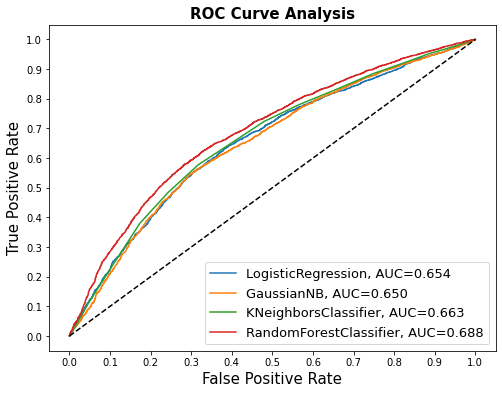

In [61]:
# Instantiate the classfiers and make a list
classifiers = [log_reg, nb, knn, rf]

# Define a result table as a DataFrame
result_table = pd.DataFrame(columns=['classifiers', 'fpr','tpr','auc'])

# Train the models and record the results
for cls in classifiers:
    model = cls.fit(scaled_X_train, y_train)
    yproba = model.predict_proba(scaled_X_val)[::,1]
    
    fpr, tpr, _ = roc_curve(y_val,  yproba)
    auc = roc_auc_score(y_val, yproba)
    
    result_table = result_table.append({'classifiers':cls.__class__.__name__,
                                        'fpr':fpr, 
                                        'tpr':tpr, 
                                        'auc':auc}, ignore_index=True)

# Set name of the classifiers as index labels
result_table.set_index('classifiers', inplace=True)
#Plot the figure
fig = plt.figure(figsize=(8,6))

for i in result_table.index:
    plt.plot(result_table.loc[i]['fpr'], 
             result_table.loc[i]['tpr'], 
             label="{}, AUC={:.3f}".format(i, result_table.loc[i]['auc']))
    
plt.plot([0,1], [0,1], color='black', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("False Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')

plt.show()

## Model Performance

In [62]:
perf = pd.DataFrame()

In [63]:
# Logistic Regression
perf['Model'] = ['Logistic Regression','K-Nearest Neighbour','Naive Baye','Random Forest']
perf['Sensitivity'] = [log_sensitivity,knn_sensitivity,nb_sensitivity,rf_sensitivity]
perf['Specificity'] = [log_specificity,knn_specificity,nb_specificity,rf_specificity]
perf['ROC AUC'] = [np.mean(log_roc_auc),np.mean(knn_roc_auc),np.mean(nb_roc_auc),np.mean(rf_roc_auc)]
perf['F1-Score'] = [np.mean(log_f1_score),np.mean(knn_f1_score),np.mean(nb_f1_score),np.mean(rf_f1_score)]
perf['Accuracy'] = [np.mean(log_accuracy),np.mean(knn_accuracy),np.mean(nb_accuracy),np.mean(rf_accuracy)]
perf['Precision'] = [np.mean(log_precision),np.mean(knn_precision),np.mean(nb_precision),np.mean(rf_precision)]
perf['Recall'] = [np.mean(log_recall),np.mean(knn_recall),np.mean(nb_recall),np.mean(rf_recall)]

In [64]:
perf

,Model,Sensitivity,Specificity,ROC AUC,F1-Score,Accuracy,Precision,Recall
0,Logistic Regression,0.019231,0.989362,0.503940,0.879746,0.786085,0.791083,0.990809
1,K-Nearest Neighbour,0.046154,0.983177,0.511798,0.878381,0.784984,0.793764,0.983209
2,Naive Baye,0.178846,0.909574,0.545508,0.854212,0.755352,0.806772,0.907590
3,Random Forest,0.009135,0.998516,0.502057,0.882401,0.789804,0.790448,0.998579


## Threshold Tuning

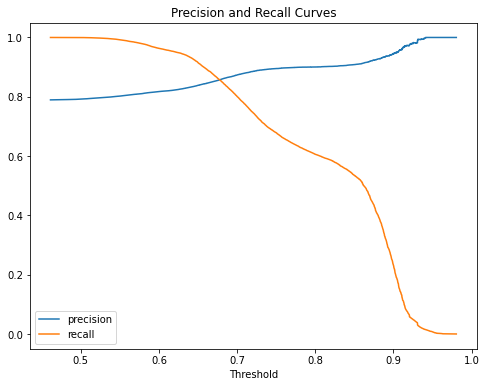

In [65]:
precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_train, rf.predict_proba(scaled_X_train)[:,1] )

fig = plt.figure(figsize=(8,6))
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold')
plt.title('Precision and Recall Curves');

In [66]:
### curves appear to taper off at about 0.7 threshold 
y_predict = (rf.predict_proba(scaled_X_val)[:, 1] >= 0.60).astype('int')
print(classification_report(y_val, y_predict))

              precision    recall  f1-score   support

           0       0.42      0.13      0.20      2609
           1       0.81      0.95      0.88     10097

    accuracy                           0.79     12706
   macro avg       0.62      0.54      0.54     12706
weighted avg       0.73      0.79      0.74     12706



## New sample for retrain/retest

In [5]:
df_imp = df

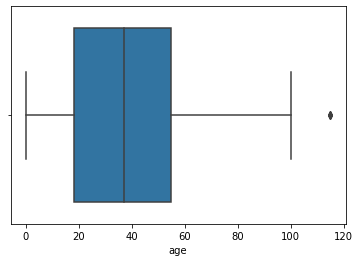

In [6]:
# Botplot to detect outlier for "age"
sns.boxplot(x=df_imp['age'])

In [7]:
# Remove outlier for "age"
def map_age(x):
    '''
    Receives an integer and returns the age category that this age is in.
    '''
    if x < 12:
        return 'Child'
    elif x > 12 and x < 18:
        return 'Teenager'
    elif x>=20 and x<25:
        return 'Young Adult'
    elif x>=25 and x<60:
        return 'Adult'
    else:
        return 'Senior'
    
df_imp['mapped_age'] = df_imp['age'].map(lambda x: map_age(x))

In [8]:
df_imp

,age,gender,app_day,month,calling_time_hour,waiting_time_minute,financial_aid,hypertension,diabetes,alcoholism,Handicap,sms_received,day_before_app,show_up,total_conditions,mapped_age
0,22,1,3,5,7,19,0,0,0,0,0,1,0,1,0,Young Adult
1,23,1,4,6,13,21,0,0,0,0,0,1,36,1,0,Young Adult
2,28,1,2,5,16,0,0,0,0,0,0,0,0,1,0,Adult
3,28,1,3,5,11,27,0,0,0,0,0,0,1,1,0,Adult
4,29,1,6,5,7,2,0,0,0,0,0,0,0,0,0,Adult
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72602,90,0,4,5,14,9,0,0,0,0,0,1,0,1,0,Senior
72603,90,0,3,5,15,0,0,0,0,0,0,0,13,1,0,Senior
72604,90,0,3,5,9,1,0,0,0,0,0,0,0,1,0,Senior
72605,90,0,4,5,8,0,0,0,0,0,0,0,8,1,0,Senior


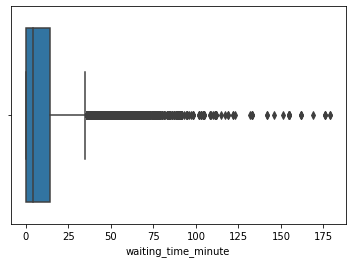

In [9]:
# Botplot to detect outlier for "waiting_time_minute"
sns.boxplot(x=df_imp['waiting_time_minute'])

In [10]:
# Remove outlier for "waiting_time_minute"
def map_waiting_time_minute(x):
    '''
    Receives an integer and returns the waiting_time_minute categories
    '''
    if x <= 30:
        return '30 mins waiting'
    elif x > 30 and x <= 60:
        return '60 mins waiting'
    elif x > 60 and x <= 90:
        return '90 mins waiting'
    elif x > 90 and x <= 120:
        return '120 mins waiting'
    else:
        return 'more than 120 mins waiting'
    
df_imp['mapped_waiting_time_minute'] = df_imp['waiting_time_minute'].map(lambda x: map_waiting_time_minute(x))

In [11]:
df_imp

,age,gender,app_day,month,calling_time_hour,waiting_time_minute,financial_aid,hypertension,diabetes,alcoholism,Handicap,sms_received,day_before_app,show_up,total_conditions,mapped_age,mapped_waiting_time_minute
0,22,1,3,5,7,19,0,0,0,0,0,1,0,1,0,Young Adult,30 mins waiting
1,23,1,4,6,13,21,0,0,0,0,0,1,36,1,0,Young Adult,30 mins waiting
2,28,1,2,5,16,0,0,0,0,0,0,0,0,1,0,Adult,30 mins waiting
3,28,1,3,5,11,27,0,0,0,0,0,0,1,1,0,Adult,30 mins waiting
4,29,1,6,5,7,2,0,0,0,0,0,0,0,0,0,Adult,30 mins waiting
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72602,90,0,4,5,14,9,0,0,0,0,0,1,0,1,0,Senior,30 mins waiting
72603,90,0,3,5,15,0,0,0,0,0,0,0,13,1,0,Senior,30 mins waiting
72604,90,0,3,5,9,1,0,0,0,0,0,0,0,1,0,Senior,30 mins waiting
72605,90,0,4,5,8,0,0,0,0,0,0,0,8,1,0,Senior,30 mins waiting


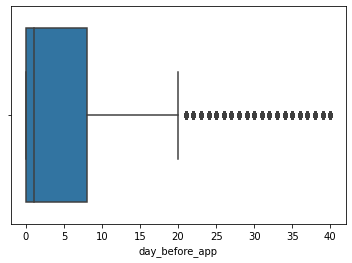

In [12]:
# Botplot to detect outlier for "day_before_app"
sns.boxplot(x=df_imp['day_before_app'])

In [13]:
# Remove outlier for "day_before_app"
def map_day_before_app(x):
    '''
    Receives an integer and returns the waiting_time_minute categories
    '''
    if x <= 7:
        return '1 week'
    elif x > 7 and x <= 14:
        return '2 weeks'
    elif x > 14 and x <= 21:
        return '3 weeks'
    elif x > 21 and x <= 28:
        return '4 weeks'
    else:
        return '1 month'
    
df_imp['mapped_day_before_app'] = df_imp['day_before_app'].map(lambda x: map_day_before_app(x))

In [14]:
df_imp

,age,gender,app_day,month,calling_time_hour,waiting_time_minute,financial_aid,hypertension,diabetes,alcoholism,Handicap,sms_received,day_before_app,show_up,total_conditions,mapped_age,mapped_waiting_time_minute,mapped_day_before_app
0,22,1,3,5,7,19,0,0,0,0,0,1,0,1,0,Young Adult,30 mins waiting,1 week
1,23,1,4,6,13,21,0,0,0,0,0,1,36,1,0,Young Adult,30 mins waiting,1 month
2,28,1,2,5,16,0,0,0,0,0,0,0,0,1,0,Adult,30 mins waiting,1 week
3,28,1,3,5,11,27,0,0,0,0,0,0,1,1,0,Adult,30 mins waiting,1 week
4,29,1,6,5,7,2,0,0,0,0,0,0,0,0,0,Adult,30 mins waiting,1 week
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72602,90,0,4,5,14,9,0,0,0,0,0,1,0,1,0,Senior,30 mins waiting,1 week
72603,90,0,3,5,15,0,0,0,0,0,0,0,13,1,0,Senior,30 mins waiting,2 weeks
72604,90,0,3,5,9,1,0,0,0,0,0,0,0,1,0,Senior,30 mins waiting,1 week
72605,90,0,4,5,8,0,0,0,0,0,0,0,8,1,0,Senior,30 mins waiting,2 weeks


In [15]:
# One-hot encoding:
from sklearn.preprocessing import OneHotEncoder

In [16]:
# creating instance of one-hot-encoder
enc = OneHotEncoder(handle_unknown='ignore')
# passing mapped_age column (label encoded values of age_types)
enc_df = pd.DataFrame(enc.fit_transform(df_imp[['mapped_age','mapped_waiting_time_minute','mapped_day_before_app']]).toarray())
# merge with main df_impf on key values
df_imp = df_imp.join(enc_df)
# rename column
df_imp.rename(columns = {0:'age_type_adult', 1:'age_type_child', 2:'age_type_senior',
                         3:'age_type_teenager',4:'age_type_young_adult', 
                         5:'waiting_120_mins',6:'waiting_30_mins', 7:'waiting_60_mins',
                         8:'waiting_90_mins',9:'waiting_120_mins',
                         10:'day_b_app_1_month', 11:'day_b_app_1_week',
                         12:'day_b_app_2_weeks',13:'day_b_app_3_weeks', 14:'day_b_app_4_weeks'
                        }, inplace = True)
df_imp

,age,gender,app_day,month,calling_time_hour,waiting_time_minute,financial_aid,hypertension,diabetes,alcoholism,...,waiting_120_mins,waiting_30_mins,waiting_60_mins,waiting_90_mins,waiting_120_mins,day_b_app_1_month,day_b_app_1_week,day_b_app_2_weeks,day_b_app_3_weeks,day_b_app_4_weeks
0,22,1,3,5,7,19,0,0,0,0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,23,1,4,6,13,21,0,0,0,0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,28,1,2,5,16,0,0,0,0,0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,28,1,3,5,11,27,0,0,0,0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,29,1,6,5,7,2,0,0,0,0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72602,90,0,4,5,14,9,0,0,0,0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
72603,90,0,3,5,15,0,0,0,0,0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
72604,90,0,3,5,9,1,0,0,0,0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
72605,90,0,4,5,8,0,0,0,0,0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [17]:
# Drop reduntant columns
df_encoded = df_imp.drop(['age','mapped_age','waiting_time_minute','mapped_waiting_time_minute',
                          'day_before_app','mapped_day_before_app'], axis=1)

# Change data type to int:
df_encoded = df_encoded.astype(int)

In [18]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72607 entries, 0 to 72606
Data columns (total 27 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   gender                72607 non-null  int64
 1   app_day               72607 non-null  int64
 2   month                 72607 non-null  int64
 3   calling_time_hour     72607 non-null  int64
 4   financial_aid         72607 non-null  int64
 5   hypertension          72607 non-null  int64
 6   diabetes              72607 non-null  int64
 7   alcoholism            72607 non-null  int64
 8   Handicap              72607 non-null  int64
 9   sms_received          72607 non-null  int64
 10  show_up               72607 non-null  int64
 11  total_conditions      72607 non-null  int64
 12  age_type_adult        72607 non-null  int64
 13  age_type_child        72607 non-null  int64
 14  age_type_senior       72607 non-null  int64
 15  age_type_teenager     72607 non-null  int64
 16  age_

In [19]:
#Feature selection using Random forest
X, y = df_encoded.drop(['show_up'],axis=1), df_encoded['show_up'] 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=44, shuffle=True)

In [20]:
sel = SelectFromModel(RandomForestClassifier(n_estimators = 100))
sel.fit(X_train, y_train)

SelectFromModel(estimator=RandomForestClassifier())

In [21]:
#To see which features are important we can use get_support method on the fitted model.
sel.get_support()

array([ True,  True,  True,  True, False, False, False, False, False,
        True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False])

In [22]:
selected_feat= X_train.columns[(sel.get_support())]
len(selected_feat)

5

In [23]:
print(selected_feat)

Index(['gender', 'app_day', 'month', 'calling_time_hour', 'sms_received'], dtype='object')


In [24]:
df_encoded

,gender,app_day,month,calling_time_hour,financial_aid,hypertension,diabetes,alcoholism,Handicap,sms_received,...,waiting_120_mins,waiting_30_mins,waiting_60_mins,waiting_90_mins,waiting_120_mins,day_b_app_1_month,day_b_app_1_week,day_b_app_2_weeks,day_b_app_3_weeks,day_b_app_4_weeks
0,1,3,5,7,0,0,0,0,0,1,...,0,1,0,0,0,0,1,0,0,0
1,1,4,6,13,0,0,0,0,0,1,...,0,1,0,0,0,1,0,0,0,0
2,1,2,5,16,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
3,1,3,5,11,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
4,1,6,5,7,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72602,0,4,5,14,0,0,0,0,0,1,...,0,1,0,0,0,0,1,0,0,0
72603,0,3,5,15,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
72604,0,3,5,9,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
72605,0,4,5,8,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0


In [25]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72607 entries, 0 to 72606
Data columns (total 27 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   gender                72607 non-null  int64
 1   app_day               72607 non-null  int64
 2   month                 72607 non-null  int64
 3   calling_time_hour     72607 non-null  int64
 4   financial_aid         72607 non-null  int64
 5   hypertension          72607 non-null  int64
 6   diabetes              72607 non-null  int64
 7   alcoholism            72607 non-null  int64
 8   Handicap              72607 non-null  int64
 9   sms_received          72607 non-null  int64
 10  show_up               72607 non-null  int64
 11  total_conditions      72607 non-null  int64
 12  age_type_adult        72607 non-null  int64
 13  age_type_child        72607 non-null  int64
 14  age_type_senior       72607 non-null  int64
 15  age_type_teenager     72607 non-null  int64
 16  age_

In [47]:
df_selected_feat = df_encoded[['gender', 'app_day', 'month','calling_time_hour','sms_received','show_up']].copy()
df_selected_feat

,gender,app_day,month,calling_time_hour,sms_received,show_up
0,1,3,5,7,1,1
1,1,4,6,13,1,1
2,1,2,5,16,0,1
3,1,3,5,11,0,1
4,1,6,5,7,0,0
...,...,...,...,...,...,...
72602,0,4,5,14,1,1
72603,0,3,5,15,0,1
72604,0,3,5,9,0,1
72605,0,4,5,8,0,1


In [48]:
df_selected_feat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72607 entries, 0 to 72606
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   gender             72607 non-null  int64
 1   app_day            72607 non-null  int64
 2   month              72607 non-null  int64
 3   calling_time_hour  72607 non-null  int64
 4   sms_received       72607 non-null  int64
 5   show_up            72607 non-null  int64
dtypes: int64(6)
memory usage: 3.3 MB
